In [101]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [102]:
words = open('names.txt', 'r').read().splitlines()
words[:10], len(words)

(['emma',
  'olivia',
  'ava',
  'isabella',
  'sophia',
  'charlotte',
  'mia',
  'amelia',
  'harper',
  'evelyn'],
 32033)

In [103]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [104]:
# build the dataset

block_size = 3

def build_dataset(words, block_size):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

In [105]:
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1], block_size=block_size)
Xdev, Ydev = build_dataset(words[n1:n2], block_size=block_size)
Xte, Yte = build_dataset(words[n2:], block_size=block_size)

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [106]:
# MLP
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g)
# W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size) ** 0.5)
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.ones((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b2, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # total number of parameters
for p in parameters:
  p.requires_grad = True

12124


tensor(-0.0160) tensor(0.9997)
tensor(-0.0374) tensor(9.8978)


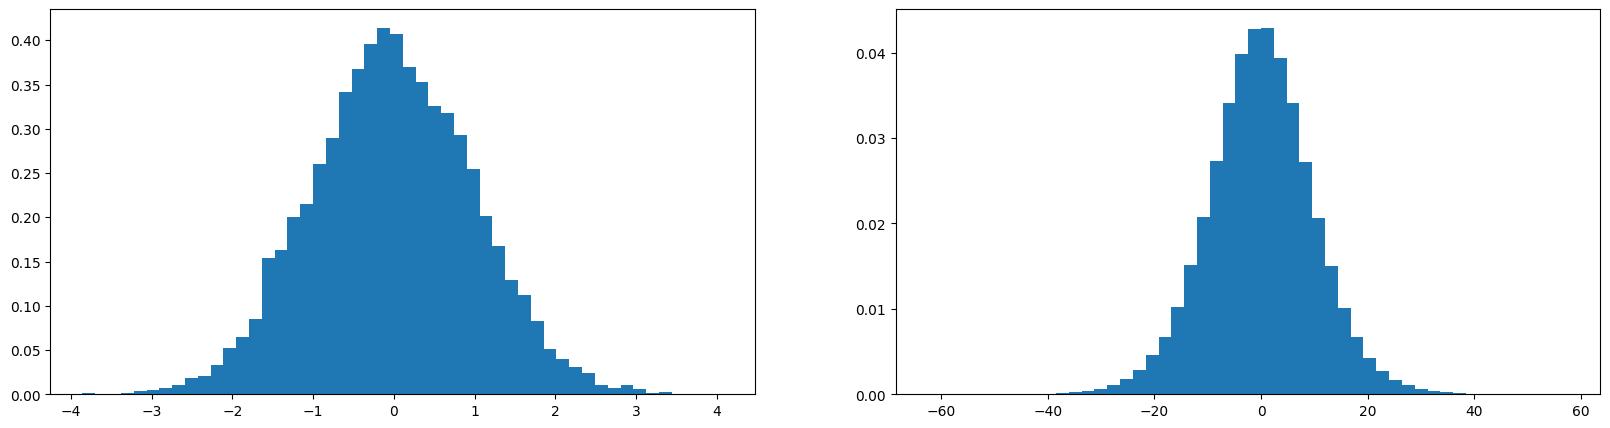

In [107]:
x = torch.randn(1000, 10)
# w = torch.randn(10, 200)
w = torch.randn(10, 200) * (10 ** 0.5)
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

In [108]:
# (torch.randn(1000000)).std()
(torch.randn(1000000) * 0.7).std()

tensor(0.6989)

In [109]:
n_embd * block_size

30

In [110]:
(5 / 3) / (30 ** 0.5)

0.3042903097250923

In [111]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  emb = C[Xb]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias

  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Yb)

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data -= lr * p.grad

  # track stats
  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  # break

      0/ 200000: 3.3147
  10000/ 200000: 2.1909
  20000/ 200000: 2.3221
  30000/ 200000: 2.4388
  40000/ 200000: 2.0089
  50000/ 200000: 2.2936
  60000/ 200000: 2.4981
  70000/ 200000: 2.1200
  80000/ 200000: 2.2933
  90000/ 200000: 2.1784
 100000/ 200000: 2.0199
 110000/ 200000: 2.3067
 120000/ 200000: 1.9450
 130000/ 200000: 2.4594
 140000/ 200000: 2.3683
 150000/ 200000: 2.2553
 160000/ 200000: 2.0477
 170000/ 200000: 1.8780
 180000/ 200000: 2.0366
 190000/ 200000: 1.8371


In [112]:
hpreact.shape

torch.Size([32, 200])

In [113]:
hpreact.mean(0, keepdim=True).shape

torch.Size([1, 200])

In [114]:
hpreact.std(0, keepdim=True).shape

torch.Size([1, 200])

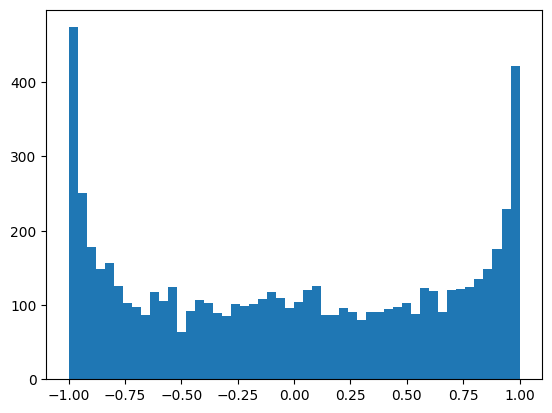

In [115]:
plt.hist(h.view(-1).tolist(), 50);

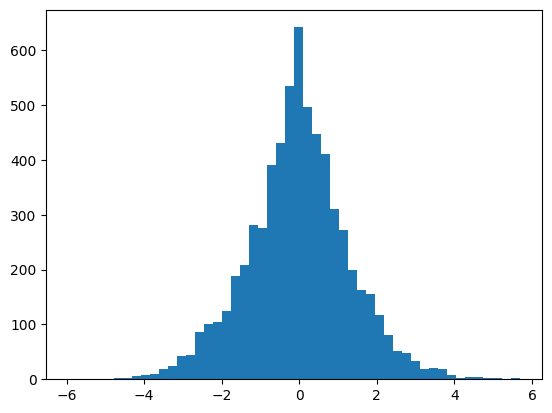

In [116]:
plt.hist(hpreact.view(-1).tolist(), 50);

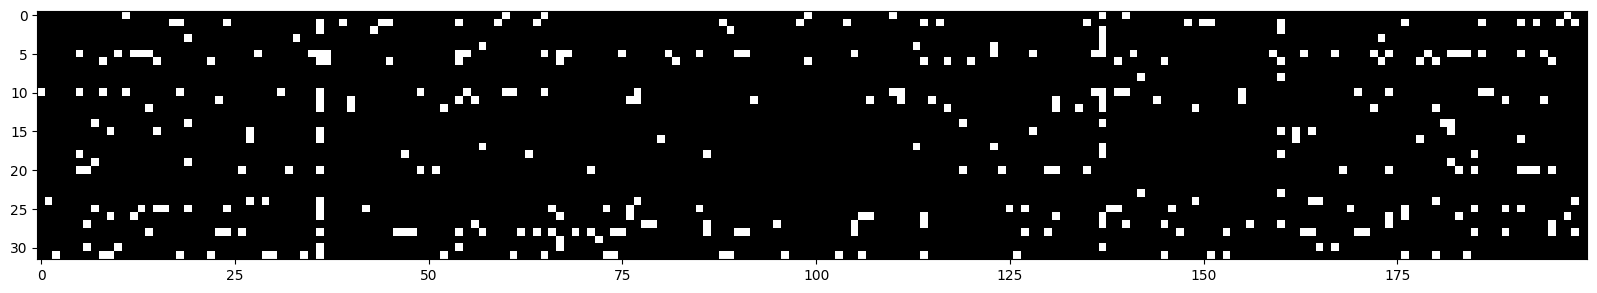

In [117]:
# good that there is no column of white
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest');

In [118]:
# logits[0]

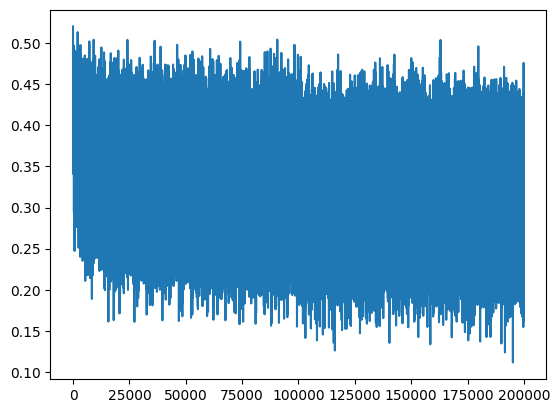

In [119]:
plt.plot(lossi);

In [120]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)

In [128]:
bnmean

tensor([[-2.3783e+00,  7.2955e-01, -7.7322e-01,  1.1522e+00,  1.1377e+00,
          1.0626e+00,  2.0392e+00, -1.9416e+00,  5.6887e-01,  1.2529e+00,
         -1.9291e+00, -2.7966e+00, -8.5094e-01, -1.1393e-01, -2.6592e-02,
         -1.0950e+00,  8.8685e-01, -2.6286e+00,  2.7857e-01,  1.3515e+00,
         -7.3522e-01, -1.4618e-01,  3.3495e-01,  6.3101e-01,  9.8678e-01,
          2.0798e-01,  1.9499e+00,  9.9567e-02,  5.6665e-01,  1.8042e+00,
         -2.3413e-01, -1.1848e+00, -9.2093e-01, -1.6470e-01, -4.6197e-01,
         -1.3520e+00, -2.3865e+00,  4.8566e-01, -5.2243e-01,  8.1730e-01,
         -3.4693e-01, -1.3566e+00, -2.3666e-01, -1.8834e-01,  8.4635e-01,
          5.7904e-01,  1.9311e+00, -6.6980e-01,  1.7608e+00,  1.7116e+00,
          7.5900e-01,  9.5617e-02,  1.7324e+00,  6.2542e-01,  9.3564e-01,
         -1.9507e+00, -1.3218e-01,  3.4063e-01,  1.4127e+00, -1.2169e+00,
         -3.8288e-01,  9.4358e-01,  5.9500e-01,  3.6119e-01,  1.7303e+00,
          9.0682e-01, -1.1629e+00,  2.

In [129]:
bnmean_running

tensor([[-2.3950,  0.7403, -0.7615,  1.1525,  1.1410,  1.0573,  2.0324, -1.9585,
          0.5587,  1.2332, -1.9413, -2.7990, -0.8621, -0.1231, -0.0152, -1.0738,
          0.8954, -2.6437,  0.2526,  1.3398, -0.7352, -0.1266,  0.3281,  0.6285,
          0.9802,  0.2114,  1.9617,  0.0963,  0.5618,  1.8077, -0.2495, -1.1835,
         -0.9252, -0.1717, -0.4617, -1.3554, -2.3827,  0.4770, -0.5128,  0.8233,
         -0.3521, -1.3823, -0.2406, -0.1848,  0.8561,  0.5909,  1.9353, -0.6782,
          1.7529,  1.7000,  0.7420,  0.0916,  1.7199,  0.6233,  0.9273, -1.9550,
         -0.1338,  0.3427,  1.4226, -1.2148, -0.4023,  0.9308,  0.5860,  0.3568,
          1.7297,  0.8941, -1.1701,  2.1573, -0.4545,  0.1166,  0.1521, -0.5117,
          0.6941, -1.1467, -2.9782,  0.3838,  1.1746, -0.1782,  0.2492,  0.3988,
         -0.0045,  1.2313,  1.9767,  0.5150, -0.0781,  0.3362, -1.7509,  0.2494,
          0.7200,  0.0360, -0.6053,  1.3410, -0.3929, -1.1496, -0.7833,  0.3193,
         -0.2176,  0.1502, -

In [126]:
# bnstd

In [127]:
# bnstd_running

In [130]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x, y = {
      'train': (Xtr, Ytr),
      'val': (Xdev, Ydev),
      'test': (Xte, Yte)
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  # hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

In [124]:
split_loss('train')
split_loss('test')

train 2.066676616668701
test 2.107788562774658


In [125]:
# sample from the model
g = torch.Generator().manual_seed(214783647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size
    while True:
        # forward pass the neural net
        context_tensor = torch.tensor([context])  # Convert context to a tensor of shape (1, block_size)
        emb = C[context_tensor]  # (1, block_size, n_embd)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)  # Compute hidden layer
        logits = h @ W2 + b2  # Compute logits
        probs = F.softmax(logits, dim=1)  # Compute probabilities
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

brissadyly.
sissskbriysanthzeegammiasselsssufussiasgmarviinshamviysstts.
piseassafnabdulkiyshbyna.
zshby.
sasdsw.
sressaddudusssuffylisessaddislucasellisthfffdoyashmeariselguszatsiadizabelly.
vivizellnnesss.
lubleighttk.
zabbubrissmfrisheth.
saesuspsiaird.
quunzierusavyasfernivabraynlwh.
solnsetzavishby.
saxsitsiemasthvi.
frinnudie.
saldiseldyn.
brissimfernyellbdsiiassiahasnishelqaimfasumisluiamnishefr.
brubusasdbrias.
fellton.
qraveagudor.
priz.
